In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import scipy.io as sio
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse

# Functions

In [86]:
def plot_insole_grid(grid):
    fig = plt.figure(figsize = (8,4))
    plt.imshow(reshape_insole_grid(insoleAll_l[0]), cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Pixel intensity')
    plt.title('64x16 Array Pixel Representation')
    # plt.show()
    return fig

def reshape_insole_grid(data):
    data = data.reshape(16,64).T
    return data

def filter_coordinates(grid, threshold = 0):
    return np.argwhere(grid > threshold)

# Load&Process Data

In [87]:
data = sio.loadmat('../data/GAIT080624-01/gait_recording_080624_walk.mat')
insoleAll_l = data['insoleAll_l'].astype(np.float64)
insoleAll_r = data['insoleAll_r'].astype(np.float64)
t_insole_l = data['t_insole_l'].astype(np.float64)
t_insole_r = data['t_insole_r'].astype(np.float64)

In [89]:
insoleAll_l.shape

(9295, 1024)

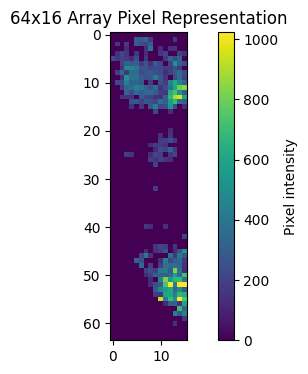

In [90]:
grid = reshape_insole_grid(insoleAll_l[1600])

fig = plot_insole_grid(grid)
fig

In [106]:
def GM_cluster(grid_coord, cluster_num = 5):
    gmm = GaussianMixture(n_components=cluster_num, covariance_type='full', random_state=42)
    gmm.fit(grid_coord)
    labels = gmm.predict(grid_coord)
    
    # Get the means (cluster centers) and covariances from the GMM
    means = gmm.means_
    covariances = gmm.covariances_
    
    fig = plt.figure(figsize = (4,12))
    
    # Plot the original coordinates and clustering
    plt.scatter(grid_coord[:, 1], grid_coord[:, 0], s=10, label='Activated Sensors', c = labels)
    
    # Plot the clustering centers
    plt.scatter(means[:, 1], means[:, 0], c='red', marker='x', s=100, label='Cluster Centers')
    
    for i, (mean, cov) in enumerate(zip(means, covariances)):
        # Compute the eigenvalues and eigenvectors for the covariance matrix
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        
        # Compute the angle for the ellipse
        angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))+90
        
        # Width and height of the ellipse correspond to the 95% confidence interval
        width, height = 2 * np.sqrt(eigenvalues) * 1.96
        
        # Create and add the ellipse patch
        ellipse = Ellipse((mean[1],mean[0]), width, height, angle = angle,edgecolor='red', facecolor='none', linestyle='--')
        plt.gca().add_patch(ellipse)
    
    plt.title(f'Gaussian Mixture Model Clustering with 95% Confidence\n Intervals with {cluster_num} Clusters')
    plt.legend()
    plt.xlim(0, 16)
    plt.ylim(0, 64)
    plt.ioff()

    return fig, means, covariances

C:\Users\jackz\.conda\envs\DL\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


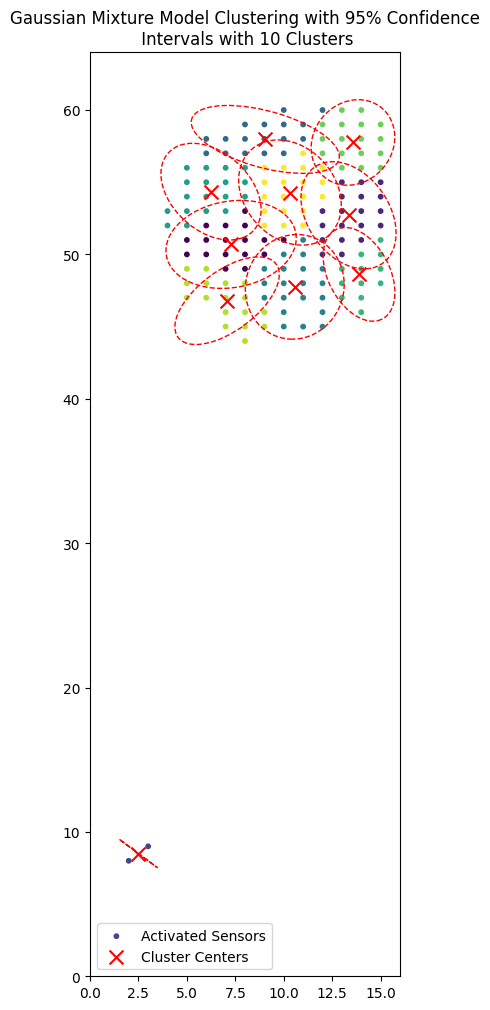

In [112]:
grid_coord = filter_coordinates(grid, threshold = 750)
fig, means,covs = GM_cluster(grid_coord, cluster_num = 10)
fig